# Call Center Data Modelling

## Posterior Confidence Intervals

### Preprocessing

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)


### Model

Likelihood: Exponential Distribution as it is the simplest Model that fits the shape of the data

Prior: Gamma distribution as it is the conjugate prior and is very customizable.

Prior parameters: Since I have very low confidence in my prior estimations, I will set alpha = 0.001, beta = 0.001. This is so that any new data that is evaluated will be much larger relative to these values and hence will quickly/ easily override any effect that the prior parameters might have on the posterior.

### Calculating Posteriors

In [4]:
# for each hour
postparams_by_hour = [None for _ in range(24)]
for i,times in enumerate(waiting_times_per_hour):
    # update posterior 
    ## Posterior = gamma(alpha+n, beta+sum(x))
    alpha = 0.001 + len(times)
    beta = 0.001 + sum(times)
    postparams_by_hour[i] = (alpha,beta)

In [5]:
meanLambda_by_hour = [None for _ in range(24)]
test = [None for _ in range(24)]

CI_by_hour = [None for _ in range(24)]
for i,postparams in enumerate(postparams_by_hour):
    meanLambda_by_hour[i] = sts.gamma.mean(postparams[0],scale=1/postparams[1])
    CI_by_hour[i] = sts.gamma.interval(0.98,postparams[0],scale=1/postparams[1])

In [9]:
from prettytable import PrettyTable

#print(tabulate([[meanLambda_by_hour[i],CI_by_hour[i]] for i in range(24)], headers=['Mean', '98% Confidence Interval'],tablefmt='orgtbl'))
t = PrettyTable(["Mean","98% Confidence Interval"])
for i in range(24):
    t.add_row([meanLambda_by_hour[i],CI_by_hour[i]])
print(t)

+---------------------+---------------------------------------------+
|         Mean        |           98% Confidence Interval           |
+---------------------+---------------------------------------------+
| 0.08211687821218043 |  (0.021010976501357217, 0.1905741173766468) |
| 0.05989431295938684 | (0.012330265998853741, 0.15039762172137183) |
|  0.0783410138248848 | (0.023313163061751994, 0.17114613158238112) |
| 0.21717651529545884 |  (0.07889839164578151, 0.4343361636035827)  |
|  0.4277113388495008 |   (0.2570052810111013, 0.6466270752684866)  |
|  0.8903092506425226 |   (0.6307090239981112, 1.1992303299694524)  |
|  1.5809405488769377 |    (1.224724863267216, 1.987105586670805)   |
|  2.8763245772201405 |    (2.3921604780349064, 3.40936419319257)   |
|  4.257946738995599  |    (3.6611754146965585, 4.90400602944679)   |
|  5.735802392371304  |    (5.041950133042432, 6.478541448276308)   |
|  8.297251791809659  |   (7.4552276367636425, 9.188469120468492)   |
|   15.3897440125383

## Plotting Posterior Confidence Intervals

In [12]:
CI_by_hour
error_bars = [[None for _ in range(24)],[None for _ in range(24)]]
for i, ci in enumerate(CI_by_hour):
    error_bars[0][i],error_bars[1][i] = (meanLambda_by_hour[i]-ci[0],ci[1]-meanLambda_by_hour[i])


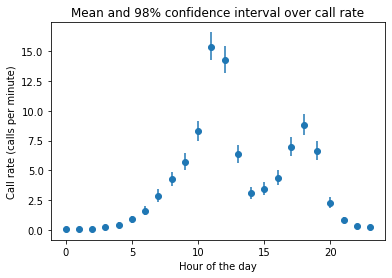

In [13]:
fig, ax = plt.subplots()
x = np.arange(0,24)
ax.errorbar(x, meanLambda_by_hour, yerr=error_bars,fmt='o')
plt.xlabel("Hour of the day");
plt.ylabel("Call rate (calls per minute)");
plt.title("Mean and 98% confidence interval over call rate");

## Presenting Findings

This plot describes the estimated number of calls we expect per minute (y-axis) differentiated by hour of the day (x-axis). Hour 0 represents midnight, and hour 23 represemts 11pm. The minimum call rate is approximately 0, and the maximum 16. 

Focusing on the dots in the plot, we can see that almost all of the calls will occur during waking hours (5am to 9pm) with the call rate being almost 0 during the late night (9pm to 5am). The call rate peaks in the early afternooon (12pm) and early evening (5pm), with the afternoon peak being significantly larger. There is a dip in the call rate after lunch time (3pm).

The uncertainty of our estimates can be evaluated through the lines visible above and below each dot in the plot. There is a 98% chance that the line contains the true average call rate. However, this is only based on the data that we have. Thus, there is always a danger that we are missing crucial information or that the information we used is wrong. That said, assuming that the data we have is representative of the actual call rates, we can be very certain that these estimates are accurate. 

_________

# Compute Posterior

1) Normally you would multiple the prior and likelihood values. In the function, we instead add the logarithms of the prior and likelihood values. This is equivalent because of the log product rule which states that: $$log(ab) = log(a) + log(b)$$

2) The sum of the logs in the likelihood calculation is essentially multiplying the likelihood from each datum that we have. It is the same as taking the product of the likelihoods that result from each datum. This is how we incorporate each likelihood resulting from each datapoint into our final posterior.

3) It removes the theta that has the largest probability density.

4) Because we need to ensure that the final posterior is a valid probablity density function, which means that it needs to integrate to 1. 

5) An example with very small values would cause a problem if we don't take logs. This is because of rounding errors in multiplication.

In [14]:
def prior(lambda_):
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)


def likelihood(lambda_, datum):
    return sts.expon(scale=1/lambda_).pdf(datum)

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

**Using Logs, we can still safely compute with small numbers**

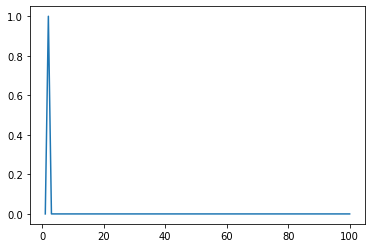

In [15]:
x_xs = np.linspace(1,100,100)
d_xs = np.linspace(1,0.0001,100)
plt.plot(x_xs, compute_posterior(x_xs, prior, likelihood, d_xs))

**Using Multiplication, rounding errors make small numbers round to 0 which can not only cause large errors, but can also make us unable to complete calculations due to 0 being an invalid value in many equations (division, logs, etc.)**

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in multiply
  


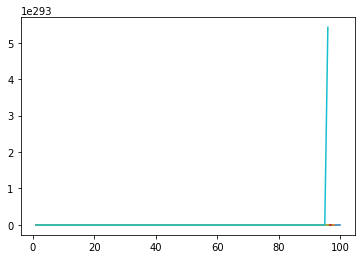

In [16]:
#prior(d_xs)

likelihood_xs = 1
for x in x_xs:
    for d in d_xs:
        likelihood_xs = likelihood_xs * likelihood(x_xs,d_xs)

    plt.plot(x_xs, likelihood_xs)